# Online CNN training on a subspace using SMC

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from functools import partial
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix

tfd = tfp.distributions

2022-09-07 09:34:57.861347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(linewidth=200, suppress=True)

In [3]:
device_cpu, *_ = jax.devices("cpu")

In [4]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [5]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

    
def fz(W):
    return W


def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle = jax.random.split(key, 3)
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    X = jnp.c_[x, y]

    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    X, y = jnp.array(X[shuffled_ixs, :].T)
    return X, y


def generate_train_test_data(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    x, y = sample_observations(key, f, n_obs, xmin, xmax, x_noise, y_noise)
    xtest = jnp.linspace(x.min(), x.max(), n_obs)
    return (x, y), (xtest, f(xtest))


class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = self.activation(x)
        x = nn.Dense(features=84)(x)
        x = self.activation(x)
        x = nn.Dense(features=self.num_classes)(x)
        # x = nn.log_softmax(x)
        return x


def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    # ix_resample = jax.random.choice(key_resample, p=weights n_particles, shape=(n_particles,))
    ix_resample = jax.random.choice(key_resample, n_particles, shape=(n_particles,))
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=0.1)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "particles": particles_next,
        "log_target": distr_cond.log_prob(particles_next).sum(axis=1) + log_weights_next
    }
    
    return state_next, memory

In [6]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_particles_init, key_smc, key_dummy, key_pm = jax.random.split(key, 6)

## Classification on a $28^2$-dimensional subspace

In [7]:
n_obs = 1000
X_train = jnp.array(mnist_train.data)[:n_obs]
y_train = jnp.array(mnist_train.targets)[:n_obs]

num_train, *_ = X_train.shape
# "Gaussanised" MNIST
X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, 10)
num_samples = len(X_train)

In [8]:
n_particles = 1500
dim_subspace = 200

model = SmallCNN(10)
batch = jnp.ones((1, 28, 28, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [10]:
dim_full = len(params_all_flat)
# proj_matrix = jax.random.bernoulli(key_pm, p=0.5, shape=(dim_full, dim_subspace)).astype(float)

# key_pm = jax.device_put(key_pm, device_cpu) # Move pmatrix to CPU if too big to fit in TPU
proj_matrix = jax.random.normal(key_pm, shape=(dim_full, dim_subspace))

particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

proj_matrix.shape

(152410, 200)

In [11]:
%%time
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train, y_ohe_train)
part_smc_step = partial(smc_step,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=10)

(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))

CPU times: user 14.6 s, sys: 66.3 ms, total: 14.7 s
Wall time: 42.3 s


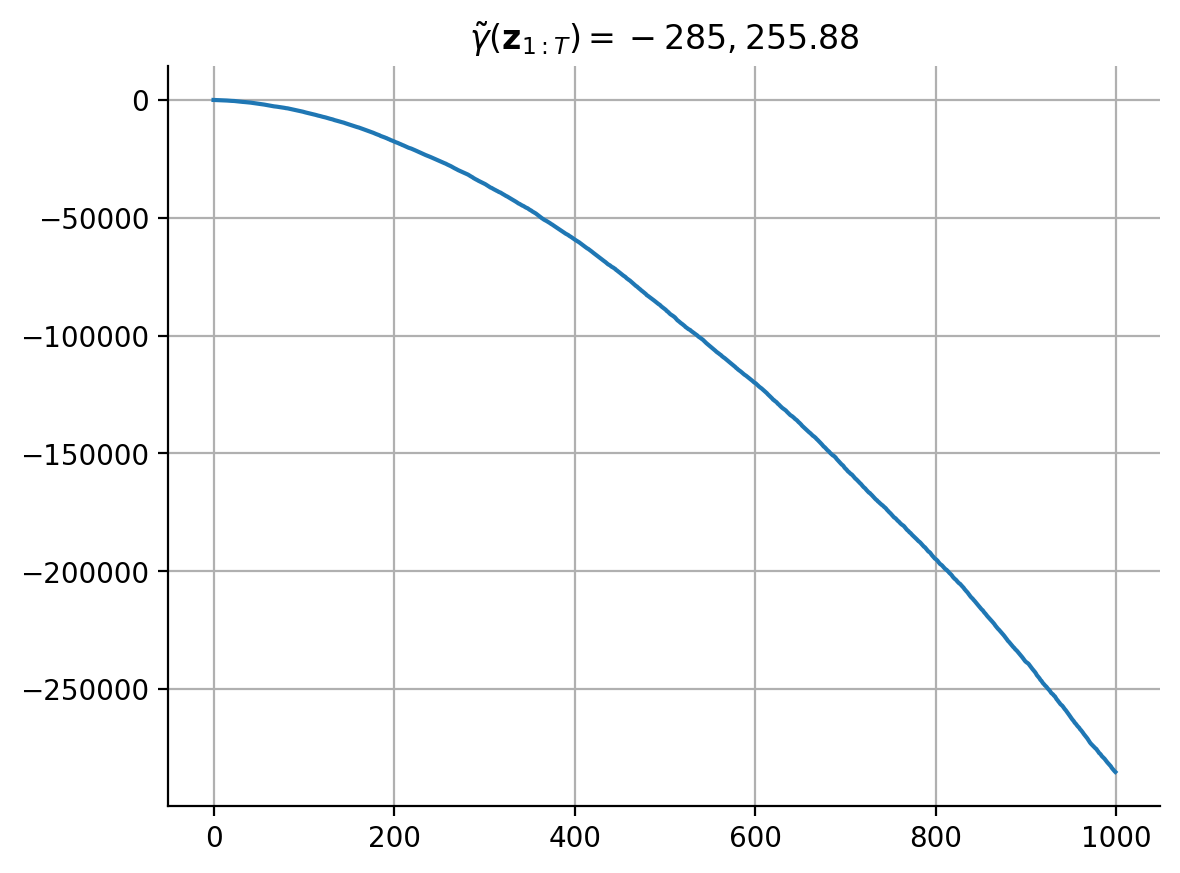

In [12]:
log_targets_hist = hist["log_target"]
# Log-unnormalised target distribution
log_utarget = log_targets_hist.sum(axis=0).mean()
plt.plot(log_targets_hist.cumsum(axis=0).mean(axis=1))
plt.title(r"$\tilde\gamma({\bf z}_{1:T})=" f"{log_utarget:,.2f}$")
plt.grid()

In [13]:
%%time 
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train_cpu[:100])
yhat_train = jax.nn.softmax(yhat_train)

tcmalloc: large alloc 2822406144 bytes == 0x561848922000 @  0x7f2baad11680 0x7f2baad32824 0x7f2baad32b8a 0x7f2ba040aff4 0x7f2b9c50b92f 0x7f2b9c51730c 0x7f2b9c51a9e5 0x7f2b9c46437a 0x7f2b9c1bef68 0x7f2b9c1a300b 0x56177251c8f4 0x5617724d647f 0x56177245020f 0x561772499300 0x561772530fe3 0x561772531cb4 0x561772415328 0x561772419171 0x5617724e030a 0x561772571e7a 0x561772530fe3 0x561772531cb4 0x5617724e030a 0x561772571e7a 0x561772530fe3 0x561772531d24 0x561772415328 0x5617725b14a2 0x5617724e01ea 0x561772571e7a 0x561772531be4
tcmalloc: large alloc 2822406144 bytes == 0x5618f1644000 @  0x7f2baad11680 0x7f2baad32824 0x7f2b9cc79ee5 0x7f2b9cd0148b 0x7f2b9cd01af9 0x7f295f5e90a3 0x7f2b9c51a9e5 0x7f2b9c46437a 0x7f2b9c1bef68 0x7f2b9c1a300b 0x56177251c8f4 0x5617724d647f 0x56177245020f 0x561772499300 0x561772530fe3 0x561772531cb4 0x561772415328 0x561772419171 0x5617724e030a 0x561772571e7a 0x561772530fe3 0x561772531cb4 0x5617724e030a 0x561772571e7a 0x561772530fe3 0x561772531d24 0x561772415328 0x5617725b

CPU times: user 20.2 s, sys: 29.4 s, total: 49.6 s
Wall time: 6 s


In [14]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=-1)
confusion_matrix(y_train[:100], yhat_train_argmax)

array([[ 1,  3,  1,  0,  0,  1,  5,  1,  0,  1],
       [ 0,  9,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  3,  0,  1,  0,  0,  0,  0,  0,  2],
       [ 0,  8,  0,  1,  1,  0,  0,  0,  0,  1],
       [ 0,  3,  0,  0,  1,  1,  2,  0,  1,  3],
       [ 0,  1,  0,  0,  2,  0,  0,  0,  0,  2],
       [ 0,  4,  0,  0,  0,  0,  7,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0,  3,  0,  1,  0],
       [ 0,  6,  0,  1,  0,  0,  1,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  1]])

In [15]:
yhat_train_argmax[:10]

DeviceArray([4, 6, 9, 6, 1, 1, 1, 9, 1, 9], dtype=int32)

In [16]:
y_train[:10]

DeviceArray([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

In [17]:
(yhat_train_argmax == y_train[:100]).mean()

DeviceArray(0.19999999, dtype=float32)